# Catan Board Generation

## Todo
- [x] Move to notebooks
- [x] Create git repo
- [x] Install git notebook extensions https://coderefinery.github.io/jupyter/version-control/
- [x] Play around with SVG library to see if it would be better https://pypi.org/project/drawSvg/
- [x] Convert point class to a collections.namedtuple https://docs.python.org/3.8/library/collections.html#collections.namedtuple
- [x] Tidy code
- [x] Refactor code so that it uses a hexagonal co-ordinate system https://www.redblobgames.com/grids/hexagons/#hex-to-pixel
- [ ] Think about metrics
- [ ] Calculate number of possible boards

In [7]:
from math import sqrt, sin, cos, pi, isclose
from __future__ import annotations
import os
from random import randint, shuffle, seed
from collections import namedtuple
from dataclasses import dataclass, field
import drawSvg as draw

seed(2022)

In [13]:
@dataclass
class Point:
    """Implements two dimensional points.
    
    Attributes:
        x: A float denoting the point's coordinate along the x axis.
        y: A float denoting the point's coordinate along the y axis.
    """
    x: float
    y: float
    
@dataclass
class Hex:
    """Implements a discrete hexagonal co-ordinate system.
    
    Three axes, q, r and s are used. Each location in the system satisfies 
    the constraint q + r + s = 0, so we don't need to request all three as
    input, as the third can be calculated (e.g. s = -q - r). 
    
    Can be extended to include features/attributes of each tile (e.g. the 
    type of terrain, height etc.)
    
    See www.redblobgames.com/grids/hexagons/ for more details on hexagonal
    co-ordinate systems.
    
    Attributes:
        q: An int denoting the hexagon's coordinate along the q axis.
        r: An int denoting the hexagon's coordinate along the r axis.
        s: An int denoting the hexagon's coordinate along the s axis.
    """
    q: int
    r: int
    s: int = field(init=False)
    
    def __post_init__(self):
        self.s = -self.q - self.r

## Functions used to generate a symbolic representation of the board

In [29]:
def init_board(radius: int) -> dict[tuple, Hex]:
    """Initialises a hexagonal shaped board of hexes.
    
    Creates a hexagonal board with a given radius. A radius of r means that the 
    minimum and maximum value for each axis is -r and r respectively. The board 
    is stored as a dict, mapping co-ordinates to the hex objects. 
    
    Args:
        radius: The radius of the board (how many hexes there are between
            the center hexes and the outer most hexes).
            
    Returns:
        A dict containing hexes, forming the base of the board. The key for the 
        hex at co-ordinates q = x and r = y is the tuple (x,y). For example: 
        
        {(0,0): Hex(q=0, r=0),
         (0,1): Hex(q=0, r=1),
         (1,0): Hex(q=1, r=0)}
        
    """
    board = {}
    for q in range(-radius, radius + 1):
        r1 = max(-radius, -q - radius)
        r2 = min(radius, -q + radius)
        for r in range(r1, r2 + 1):
            board[(q, r)] = Hex(q, r)

    return board


def add_board_features(board: dict[tuple, Hex], 
                       types: list[str], 
                       tokens: list[int]) -> None:
    """Adds types and tokens to board.
    
    To simulate a Catan board two features need to be added to each tile:
    1. The land type of the tile, and
    2. The token on the tile.
    
    Adds types and tokens to the given board randomly from the lists provided.
    Note that these changes occur in-place, so nothing is returned.
    
    Args:
        board: A dict containing hexes, as created by init_board()
        types: A list containing the types of hexes to be assigned, with the
            number of occurences of a given type corresponding to the number
            of distinct hexes it should be assigned to.
        tokens: A list containing the tokens to be assigned, with the number
            of occurences of a given tokens corresponding to the number of 
            distinct hexes it should be assigned to.
    
    """
    
    assert len(board) == len(types), ("Number of types provided must equal "
                                      "the number of hexes on the board.")
    
    assert len(board) == len(tokens) + types.count('desert'), ("Number of "
        "tokens provided must equal the total number of non-desert hexes on " 
        "the board.")

    types = types.copy()
    tokens = tokens.copy()
    
    shuffle(types)
    shuffle(tokens)
    
    for _, hex_ in board.items():
        hex_.type = types.pop()
        if hex_.type != 'desert':
            hex_.token = tokens.pop()
        else:
            hex_.token = None
        
        
def create_random_board(radius: int, 
                        types: list[str], 
                        tokens: list[int]) -> dict[tuple, Hex]:
    """Creates a randomly initialised board.
    
    Wrapper function for calling init_board() and add_board_features()
    consecutively. 
    
    Args:
        radius: An int, as described in init_board()
        types: A list of strings, as described in add_board_features()
        tokens: A list of ints, as described in add_board_features()
        
    Returns:
        board: A dict, as described in init_board()
        
    """
    board = init_board(radius)
    add_board_features(board, types, tokens)
    return board

## Functions used to create a visual representation of the board

In [78]:
def rotate(point: Point, angle: float, origin: Point=Point(0, 0)) -> Point:
    """Rotates a two dimensional point by a given angle about another point.
    
    Args:
        point: A Point, the point to rotate.
        angle: A float, the angle, in radians, to rotate point by.
        origin: A Point, the point by which to center the rotation around.
        
    Return:
        p_r: A Point, the image of point under the specified rotation.
    
    """
    p = point
    o = origin
    a = angle
    del_x = p.x - o.x
    del_y = p.y - o.y
    x = o.x + del_x * cos(a) - del_y * sin(a)
    y = o.y + del_x * sin(a) + del_y * cos(a)
    p_r = Point(x, y)
    return p_r


def hex_to_center_pixel(hex_: Hex, size: float) -> Point:
    """Converts hex coords to a single cartesian coord denoting the hex's center
    
    To render the hexes on a screen, conversion between hex co-ordinates and two 
    dimensional cartesian coordinates is required. This function converts the
    coords of the given hex to a single 2D point, which denotes the location
    of the center of the hex in the cartesian coordinate system. 
    
    Args:
        hex_: A Hex, the hex to calculate the center coord of
        size: A float, the length, in pixels, of the sides hex rendering
        
    Return:
        center: A Point, the center of the hex to be rendered
        
    """
    x = size * (sqrt(3) * hex_.q + sqrt(3)/2 * hex_.r)
    y = size * (3/2 * hex_.r)
    center = Point(x,y)
    return center


def hex_to_vertex_pixels(hex_: Hex, size: float) -> list[Point]:
    """Converts hex coords to six cartesian coords denoting the hex's vertices
    
    Similar to hex_to_center_pixel(), but calculates coords of the vertices
    instead of the coords of the center.
    
    Args:
        hex_: A Hex, the hex to calculate the vertex coords of
        size: A float, the length, in pixels, of the sides hex rendering 
        
    Return:
        points: A list of six Points, denoting the coords of the hex vertices
        
    """
    
    center = hex_to_center_pixel(hex_, size)
    p1 = Point(center.x, center.y + size)
    angles = [pi/3 * x for x in range(6)]
    points = [rotate(p1, angle, center) for angle in angles]
    return points


def points_to_coordinate_list(points: list) -> list[float]: 
    """Concatenates co-ordinates of a list of points into a list of floats.
    
    For example, the list [Point(x=1, y=2), Point(x=3, y=4)] would be flattened
    to a list of floats, [1, 2, 3, 4]. 
    
    This format is required for compatibility with the drawSvg functions.
    
    Args:
        vertices: A list of Points.
        
    Return:
        points: A list of floats, flattended coords of the points.
    
    """
    coordinates = []
    for point in points:
        coordinates.append(point.x)
        coordinates.append(point.y)
    return coordinates


def display_board(board: dict[tuple, Hex], 
                  dims: tuple,
                  hex_size: int=50) -> draw.Drawing:
    """Adds board elements to a drawing.Drawing object to visualise the board
    
    Args:
        board: A dict, as described in init_board()
        dims: A tuple, containing the desired width and height of the canvas
        hex_size: A float, the length, in pixels, of the sides hex rendering 
        
    Returns:
        d: A drawing.Drawing object, which when rendered visualise
    
    """
    
    font_family = "Open Sans"
    stroke_width = 3
    stroke_col = 'black'
    hex_colours = {
        'wool': '#a7c957',
        'grain': '#DFB853',
        'lumber': '#20703D',
        'ore': '#C37C3A',
        'brick': '#737373',
        'desert': '#DCBB96'
    }
    radius = 2 * hex_size / 5
    
    d = draw.Drawing(dims[0], dims[1], origin='center')
    
    for hex_ in board.values():
        vertex_coords = points_to_coordinate_list(
            hex_to_vertex_pixels(hex_, hex_size))
        d.append(draw.Lines(*vertex_coords,close=True,
                            fill=hex_colours[hex_.type],
                            stroke=stroke_col, stroke_width=stroke_width))
        
        center = hex_to_center_pixel(hex_, hex_size)
        
        if hex_.type != 'desert':
            if hex_.token == 6 or hex_.token == 8:
                token_color = "#E20303"
            else:
                token_color = "#000000"
            font_size = 31 - 2.5 * abs(7 - hex_.token)

            d.append(draw.Circle(center.x, center.y, 
                                 r=radius, fill="#FFEDD0"))

            d.append(draw.Text(str(hex_.token), fontSize=font_size, 
                               x=center.x, y=center.y, center=True, 
                               valign = 'middle', font_family = font_family, 
                               fill = token_color))
        
    return(d)

## Creating the board

In [25]:
types = (4 * ['wool'] + 
         4 * ['grain'] + 
         4 * ['lumber'] + 
         3 * ['ore'] + 
         3 * ['brick'] + 
         1 * ['desert'])

tokens = (1 * [2] + 
          2 * [3] + 
          2 * [4] + 
          2 * [5] + 
          2 * [6] + 
          2 * [8] + 
          2 * [9] + 
          2 * [10] + 
          2 * [11] + 
          1 * [12])

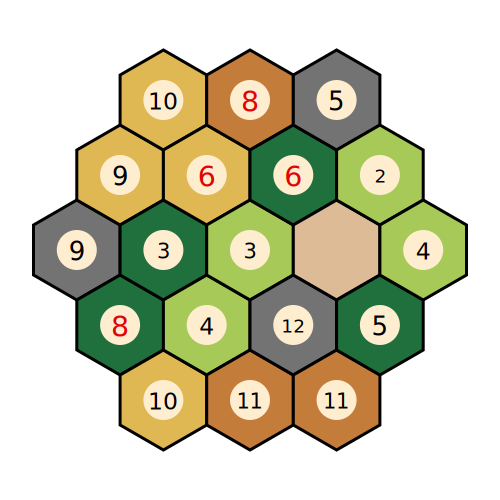

In [83]:
board = create_random_board(2, types, tokens)
board = display_board(board, (500, 500), hex_size = 50)
board.saveSvg('board.svg')
board.savePng('board.png')
board